Import libraries...


In [20]:
!pip install hmmlearn

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from datetime import datetime

Part 1: Data Collection and Preprocessing

/tmp/ipython-input-226344931.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Downloaded 2740 rows for ^GSPC.
Cleaned log returns shape: (2739, 1)
Returns stats:
Ticker        ^GSPC
count   2739.000000
mean       0.000426
std        0.011349
min       -0.127652
25%       -0.003799
50%        0.000687
75%        0.005739
max        0.090895


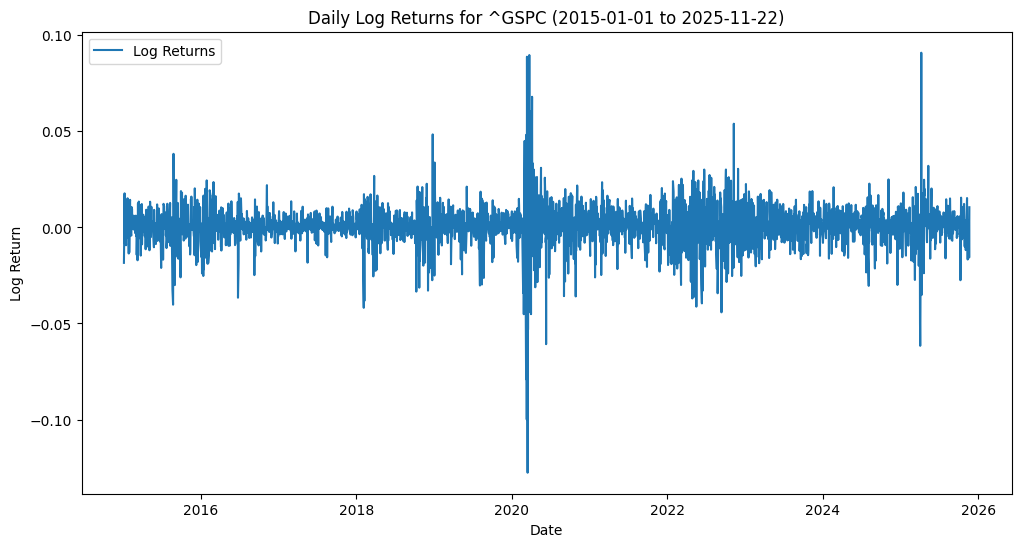

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Step 1: Data Acquisition
ticker = '^GSPC'  # S&P 500
start_date = '2015-01-01'
end_date = '2025-11-22'  # Current date as per context

data = yf.download(ticker, start=start_date, end=end_date)
print(f"Downloaded {len(data)} rows for {ticker}.")

# Step 2: Preprocessing (updated)
# Extract adjusted close (now 'Close' due to auto_adjust=True)
adj_close = data['Close'].dropna()  # Changed from 'Adj Close'

# Compute daily log returns
log_returns = np.log(adj_close / adj_close.shift(1)).dropna()

# Save cleaned data
log_returns.to_csv('sp500_log_returns.csv')
print(f"Cleaned log returns shape: {log_returns.shape}")
print(f"Returns stats:\n{log_returns.describe()}")

# Quick visualization (optional, for inspection)
plt.figure(figsize=(12, 6))
plt.plot(log_returns.index, log_returns.values, label='Log Returns')
plt.title(f'Daily Log Returns for {ticker} ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.savefig('returns_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Part 2: Gaussian Hidden Markov Model

In [23]:
from hmmlearn import hmm

# Load preprocessed returns
log_returns = pd.read_csv('sp500_log_returns.csv', index_col=0, parse_dates=True).squeeze()

# Prepare data as 2D array (required for hmmlearn)
X = log_returns.values.reshape(-1, 1)  # Shape: (n_samples, 1 feature)

# Step 1: Fit 2-state Gaussian HMM
n_states = 2
model_2 = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100, random_state=42)
model_2.fit(X)

# Predict hidden states
hidden_states_2 = model_2.predict(X)

# Step 2: Parameter Analysis
means_2 = model_2.means_.flatten()
vars_2 = model_2.covars_.flatten()

print("2-State HMM Parameters:")
for i in range(n_states):
    print(f"State {i}: Mean = {means_2[i]:.6f}, Variance = {vars_2[i]:.6f}")

# Assign labels (low vol: lower variance; high vol: higher)
state_labels = ['Low Volatility' if vars_2[i] < np.mean(vars_2) else 'High Volatility' for i in range(n_states)]
print(f"State Labels: {state_labels}")

2-State HMM Parameters:
State 0: Mean = 0.001003, Variance = 0.000051
State 1: Mean = -0.001603, Variance = 0.000430
State Labels: ['Low Volatility', 'High Volatility']


Part 3: Interpretation and Inference

Transition Matrix:
                  Low Volatility  High Volatility
Low Volatility            0.986            0.014
High Volatility           0.052            0.948


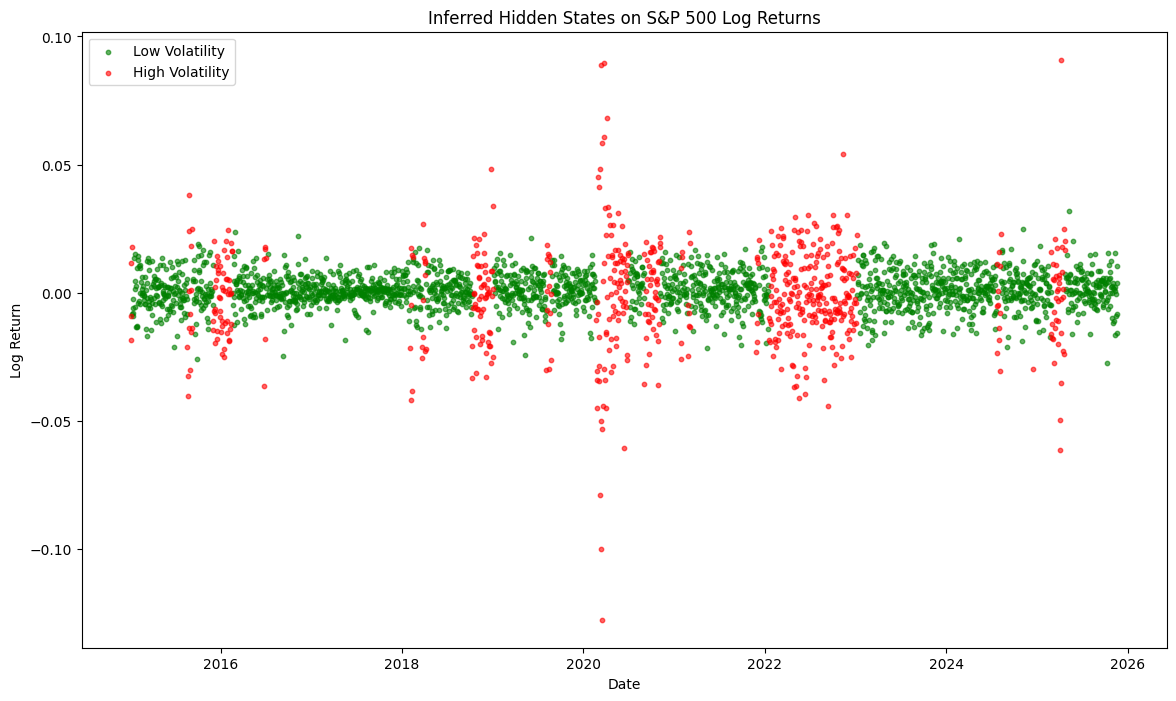

Sample State Durations (days):
 Hidden_State    0   1
Hidden_State         
1               0   4
2             154   0
3               0  14
4              58   0
5               0  52


In [24]:
# Step 1: Inferred Hidden States
# Add states to DataFrame
results_df = pd.DataFrame({
    'Date': log_returns.index,
    'Log_Return': log_returns.values,
    'Hidden_State': hidden_states_2
})
results_df['State_Label'] = [state_labels[s] for s in hidden_states_2]

# Step 2: Transition Matrix
trans_mat = pd.DataFrame(
    model_2.transmat_,
    columns=state_labels,
    index=state_labels
)
print("Transition Matrix:\n", trans_mat.round(3))

# Visualize states over time
plt.figure(figsize=(14, 8))
colors = {'Low Volatility': 'green', 'High Volatility': 'red'}
for state in state_labels:
    mask = results_df['State_Label'] == state
    plt.scatter(results_df[mask]['Date'], results_df[mask]['Log_Return'],
                c=colors[state], label=state, alpha=0.6, s=10)

plt.title('Inferred Hidden States on S&P 500 Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.savefig('states_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Transition periods analysis (e.g., duration in each state)
state_durations = results_df.groupby((results_df['Hidden_State'] != results_df['Hidden_State'].shift()).cumsum())['Hidden_State'].value_counts().unstack(fill_value=0)
print("Sample State Durations (days):\n", state_durations.head())

Part 4: Evaluation and Visualization

/tmp/ipython-input-289642962.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


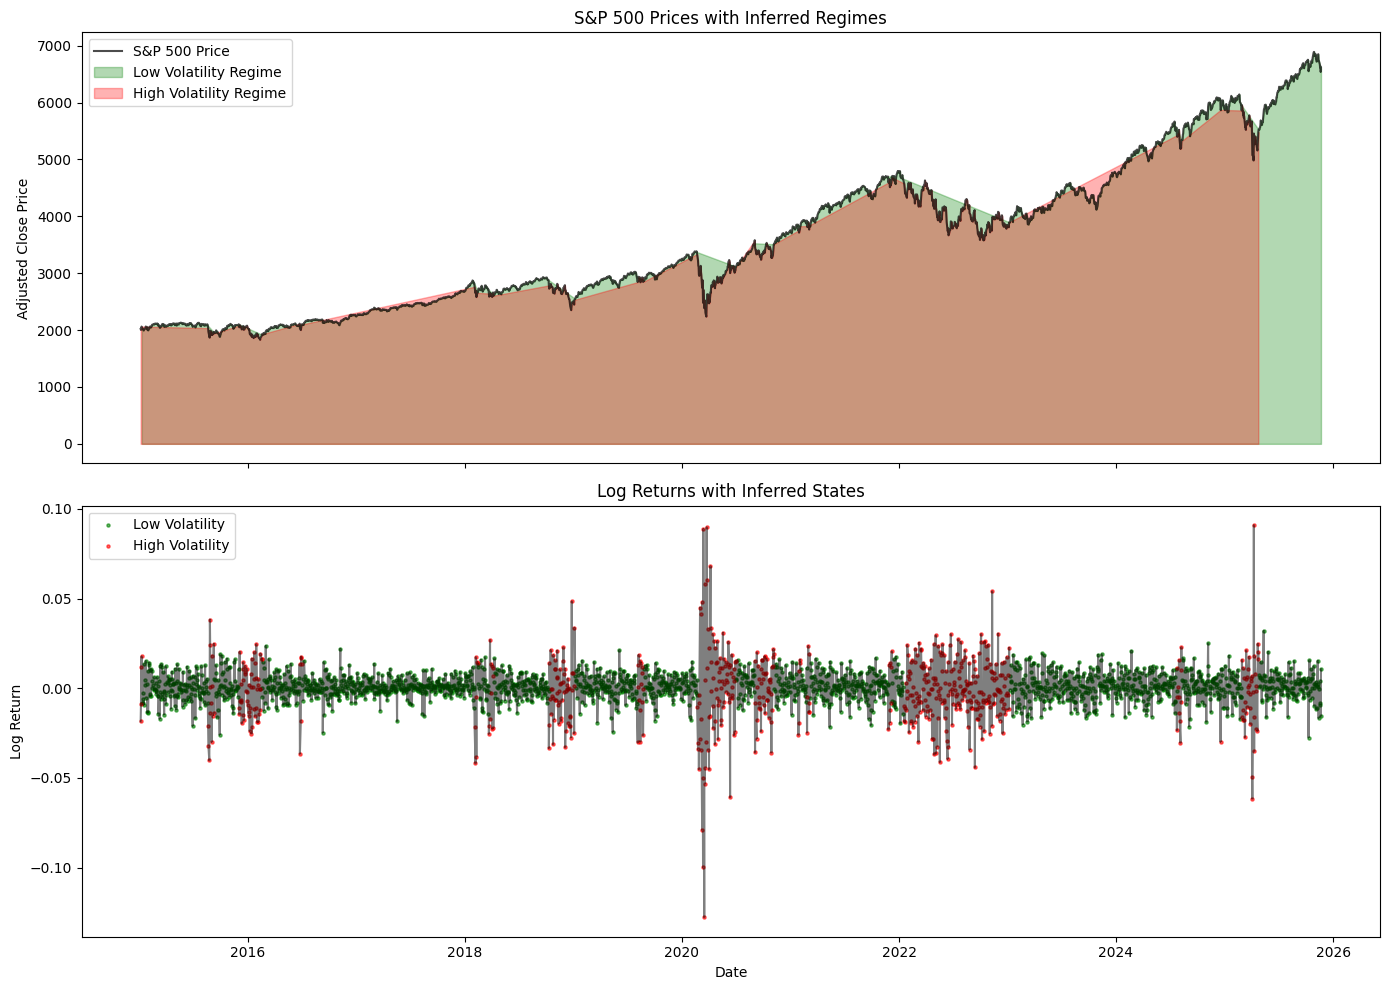

2-State Log-Likelihood: 8977.16
3-State Log-Likelihood: 8953.85 (Higher = better fit)
3-State Params: [('Stable Growth', np.float64(0.0008600383681259432), np.float64(6.796355132857791e-05)), ('Moderate Vol', np.float64(0.0010804420794060339), np.float64(5.399015552923373e-05)), ('High Vol', np.float64(-0.0021608182085329697), np.float64(0.0005051134608125235))]


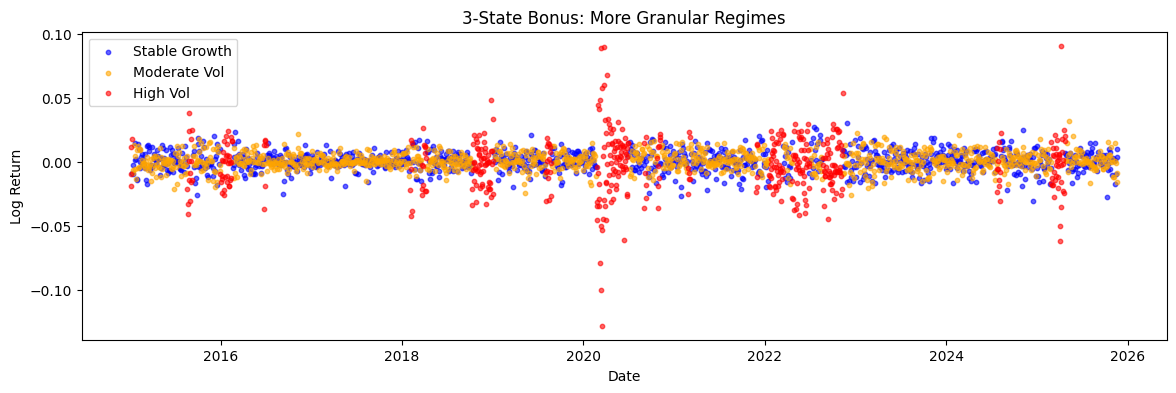

In [25]:
# Reload full data for prices
data = yf.download(ticker, start=start_date, end=end_date)
adj_close = data['Close'].dropna()  # Changed from 'Adj Close' to 'Close'

# Align states with prices (forward-fill if needed, but dates match)
results_df['Adj_Close'] = adj_close.reindex(results_df['Date']).values

# Visualization: Prices colored by states
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Prices
ax1.plot(results_df['Date'], results_df['Adj_Close'], color='black', alpha=0.7, label='S&P 500 Price')
for state in state_labels:
    mask = results_df['State_Label'] == state
    ax1.fill_between(results_df[mask]['Date'], results_df['Adj_Close'][mask], alpha=0.3,
                     color=colors[state], label=f'{state} Regime')

ax1.set_title('S&P 500 Prices with Inferred Regimes')
ax1.set_ylabel('Adjusted Close Price')
ax1.legend()

# Returns with states (from earlier plot, reuse)
ax2.plot(results_df['Date'], results_df['Log_Return'], color='black', alpha=0.5)
for state in state_labels:
    mask = results_df['State_Label'] == state
    ax2.scatter(results_df[mask]['Date'], results_df[mask]['Log_Return'],
                c=colors[state], alpha=0.6, s=5, label=state)
ax2.set_title('Log Returns with Inferred States')
ax2.set_ylabel('Log Return')
ax2.set_xlabel('Date')
ax2.legend()

plt.tight_layout()
plt.savefig('prices_states_eval.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Evaluation: Log-likelihood
print(f"2-State Log-Likelihood: {model_2.score(X):.2f}")

# Bonus: 3-State Model
n_states_bonus = 3
model_3 = hmm.GaussianHMM(n_components=n_states_bonus, covariance_type="diag", n_iter=100, random_state=42)
model_3.fit(X)
hidden_states_3 = model_3.predict(X)
ll_3 = model_3.score(X)

print(f"3-State Log-Likelihood: {ll_3:.2f} (Higher = better fit)")
means_3 = model_3.means_.flatten()
vars_3 = model_3.covars_.flatten()
state_labels_3 = ['Stable Growth', 'Moderate Vol', 'High Vol']  # Interpreted by increasing var
print("3-State Params:", list(zip(state_labels_3, means_3, vars_3)))

# Quick 3-state plot (similar to above)
plt.figure(figsize=(14, 4))
colors_3 = ['blue', 'orange', 'red']
for i, state in enumerate(state_labels_3):
    mask = hidden_states_3 == i
    plt.scatter(results_df[mask]['Date'], results_df[mask]['Log_Return'],
                c=colors_3[i], label=state, alpha=0.6, s=10)
plt.title('3-State Bonus: More Granular Regimes')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.savefig('bonus_3states.png', dpi=300, bbox_inches='tight')
plt.show()

Part 5: Conclusions and Insights

In [26]:
# Future State Prediction (simple: based on last state)
last_state = hidden_states_2[-1]
next_state_probs = model_2.transmat_[last_state]
predicted_next = np.argmax(next_state_probs)
print(f"Last State: {state_labels[last_state]}")
print(f"Transition Probs from Last: {dict(zip(state_labels, next_state_probs))}")
print(f"Predicted Next State: {state_labels[predicted_next]} (Prob: {next_state_probs[predicted_next]:.3f})")

Last State: Low Volatility
Transition Probs from Last: {'Low Volatility': np.float64(0.9856208916062948), 'High Volatility': np.float64(0.014379108393705214)}
Predicted Next State: Low Volatility (Prob: 0.986)


Bonus Task

In [27]:
# Compare with AAPL (updated for yfinance default)
aapl_data = yf.download('AAPL', start=start_date, end=end_date)['Close']  # Changed from 'Adj Close' to 'Close'
aapl_returns = np.log(aapl_data / aapl_data.shift(1)).dropna().values.reshape(-1, 1)
model_aapl = hmm.GaussianHMM(n_components=2, random_state=42)
model_aapl.fit(aapl_returns)
print("AAPL 2-State Vars:", model_aapl.covars_.flatten())
# AAPL shows higher vol overall vs. S&P (more company-specific risk).

/tmp/ipython-input-2423454848.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_data = yf.download('AAPL', start=start_date, end=end_date)['Close']  # Changed from 'Adj Close' to 'Close'
[*********************100%***********************]  1 of 1 completed

AAPL 2-State Vars: [0.00017471 0.00153766]
